In [79]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import random

2.3.0


In [80]:
with np.load("notMNIST.npz") as data :
    Data, Target = data ["images"], data["labels"]
    posClass = 2
    negClass = 9
    dataIndx = (Target==posClass) + (Target==negClass)
    Data = Data[:,:,dataIndx[:,0]]/255.
    Target = Target[dataIndx].reshape(-1, 1)
    Target[Target==posClass] = 1
    Target[Target==negClass] = 0
    np.random.seed(521)
    randIndx = np.arange(Data.shape[2])
    np.random.shuffle(randIndx)
    Data, Target = Data[:,:,randIndx], Target[randIndx]
    traindata, traintarget = Data[:,:,:3500], Target[:3500]
    validdata, validtarget = Data[:,:,3500:3600], Target[3500:3600]
    testdata, testtarget = Data[:,:,3600:], Target[3600:]

[1]
[0]


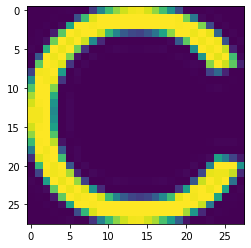

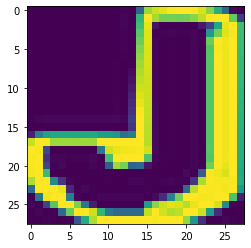

In [25]:
plt.figure()
plt.imshow(traindata[:,:,3300])
print(traintarget[3300])
plt.figure()
plt.imshow(traindata[:,:,2500])
print(traintarget[2500])

In [81]:
trainData = np.resize(traindata,(784,3500)).T
trainTarget = np.resize(traintarget,(1,3500)).T
validData = np.resize(validdata,(784,100)).T
validTarget = np.resize(validtarget,(1,100)).T
testData = np.resize(testdata,(784,141)).T
testTarget = np.resize(testtarget,(1,141)).T
print(np.shape(trainData))
print(np.shape(trainTarget))
print(np.shape(validData))
print(np.shape(validTarget))
print(np.shape(testData))
print(np.shape(testTarget))

(3500, 784)
(3500, 1)
(100, 784)
(100, 1)
(141, 784)
(141, 1)


In [82]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.w = tf.Variable(tf.random.uniform([784,1],-1,1),trainable=True,dtype=np.float32,name='w')
    self.b = tf.Variable(tf.random.uniform([1,1],-1,1),trainable=True,dtype=np.float32,name='bias')

  def call(self, x):
    y = ( tf.math.exp(tf.matmul(tf.transpose(self.w),x)+self.b) )/( 1 + tf.math.exp(tf.matmul(tf.transpose(self.w),x)+self.b))
    return y



In [1034]:
##### BCE

In [1349]:
# Create an instance of the model
model = MyModel()

In [1350]:
optimizer = tf.keras.optimizers.Adam(learning_rate=.001)

In [1351]:
def train_step(X, Y):
    with tf.GradientTape() as tape:
        lo=[]
        for idx in range(X.shape[0]):
            Y_predicted = model(np.resize(X[idx,:],(784,1)))
            Y_predicted = tf.clip_by_value(Y_predicted, 1e-7, 1. - 1e-7)
            los = Y[idx]*tf.math.log(Y_predicted) + (1-Y[idx])*tf.math.log(1-Y_predicted)
            lo.append(los)
        loss = -tf.math.reduce_mean(lo)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [1352]:
def find_Loss_Accuracy(X, Y):
    Loss_list=[]
    Accuracy_list=[]
    for idx in range(X.shape[0]):
        Y_predicted = model(np.resize(X[idx,:],(784,1)))
        Y_mask = tf.round(Y_predicted)
        if Y[idx]==Y_mask:
           Accuracy_list.append(1)
        Y_predicted = tf.clip_by_value(Y_predicted, 1e-7, 1. - 1e-7)
        loss = Y[idx]*tf.math.log(Y_predicted)+(1-Y[idx])*tf.math.log(1-Y_predicted)
        Loss_list.append(loss)
    return -np.mean(Loss_list), sum(Accuracy_list)/X.shape[0]

In [1353]:
Data_len=trainData.shape[0]
batch_size=2
n_epochs=15
train_Loss_Accuracy_list = []
val_Loss_Accuracy_list = []
w_list = []
temp = list(zip(trainData, trainTarget))
for i in range (n_epochs):
    random.shuffle(temp) 
    res1, res2 = zip(*temp)
    trainDataa = np.array(res1)
    trainTargett = np.array(res2)
    for idx in range(int(Data_len/batch_size)):
        X_batch = trainDataa[idx*batch_size:(idx+1)*batch_size,:]
        Y_batch = trainTargett[idx*batch_size:(idx+1)*batch_size]
        train_step(X_batch,Y_batch)
    w_list.append(model.w.numpy())
    print(" Train Loss and Accuracy:", end="")
    print(find_Loss_Accuracy(trainData,trainTarget))
    train_Loss_Accuracy_list.append(find_Loss_Accuracy(trainData,trainTarget))
    print(" Valid Loss and Accuracy:", end="")
    print(find_Loss_Accuracy(validData,validTarget))
    val_Loss_Accuracy_list.append(find_Loss_Accuracy(validData,validTarget))
    print('%%%%%%%%%%%%%%%%%')
print(" Test Loss and Accuracy:", end="")
print(find_Loss_Accuracy(testData,testTarget))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

 Train Loss and Accuracy:(0.15042393, 0.9611428571428572)
 Valid Loss and Accuracy:(0.05062646, 0.99)
%%%%%%%%%%%%%%%%%
 Train Loss and Accuracy:(0.11329407, 0.9694285714285714)
 Valid Loss and Accuracy:(0.034263395, 0.99)
%%%%%%%%%%%%%%%%%
 Train Loss and Accuracy:(0.094847575, 0.9748571428571429)
 Valid Loss and Accuracy:(0.025201192, 0.99)
%%%%%%%%%%%%%%%%%
 Train Loss and Accuracy:(0.10196861, 0.9751428571428571)
 Valid Loss and Accuracy:(0.016912544, 0.99)
%%%%%%%%%%%%%%%%%
 Train Loss and Accuracy

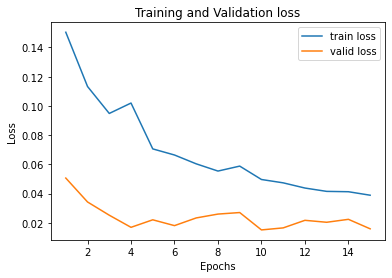

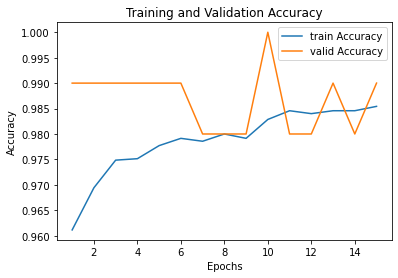

In [1371]:
epochs = range(1,16)
plt.figure()
plt.plot(epochs, np.array(train_Loss_Accuracy_list)[:,0], label='train loss')
plt.plot(epochs, np.array(val_Loss_Accuracy_list)[:,0], label='valid loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Training and Validation loss(BCE)', dpi=1000)
plt.figure()
plt.plot(epochs, np.array(train_Loss_Accuracy_list)[:,1], label='train Accuracy')
plt.plot(epochs, np.array(val_Loss_Accuracy_list)[:,1], label='valid Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Training and Validation Accuracy(BCE)', dpi=1000)

In [ ]:
##### ML

In [1379]:
# Create an instance of the model
model = MyModel()

In [1380]:
optimizer = tf.keras.optimizers.Adam(learning_rate=.001)

In [1381]:
def train_step_v2(X, Y):
    with tf.GradientTape() as tape:
        lo=[]
        for idx in range(X.shape[0]):
            Y_predicted = model(np.resize(X[idx,:],(784,1)))
            if Y[idx]==1:
                los = Y_predicted
            else:
                los = 1 - Y_predicted
            lo.append(los)
        loss = -tf.math.reduce_mean(lo)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [1383]:
def find_Loss_Accuracy_v2(X, Y):
    Loss_list=[]
    Accuracy_list=[]
    for idx in range(X.shape[0]):
        Y_predicted = model(np.resize(X[idx,:],(784,1)))
        Y_mask = tf.round(Y_predicted)
        if Y[idx]==Y_mask:
           Accuracy_list.append(1)
        if Y[idx]==1:
            loss = Y_predicted
        else:
            loss = (1-Y_predicted)
        Loss_list.append(loss)
    return -np.mean(Loss_list), sum(Accuracy_list)/X.shape[0]

In [1384]:
Data_len=trainData.shape[0]
batch_size=2
n_epochs=15
train_Loss_Accuracy_list = []
val_Loss_Accuracy_list = []
w_list = []
temp = list(zip(trainData, trainTarget))
for i in range (n_epochs):
    random.shuffle(temp) 
    res1, res2 = zip(*temp)
    trainDataa = np.array(res1)
    trainTargett = np.array(res2)
    for idx in range(int(Data_len/batch_size)):
        X_batch = trainDataa[idx*batch_size:(idx+1)*batch_size,:]
        Y_batch = trainTargett[idx*batch_size:(idx+1)*batch_size]
        train_step_v2(X_batch,Y_batch)
    w_list.append(model.w.numpy())
    print(" Train Loss and Accuracy:", end="")
    print(find_Loss_Accuracy_v2(trainData,trainTarget))
    train_Loss_Accuracy_list.append(find_Loss_Accuracy_v2(trainData,trainTarget))
    print(" Valid Loss and Accuracy:", end="")
    print(find_Loss_Accuracy_v2(validData,validTarget))
    val_Loss_Accuracy_list.append(find_Loss_Accuracy_v2(validData,validTarget))
    print('%%%%%%%%%%%%%%%%%')
print(" Test Loss and Accuracy:", end="")
print(find_Loss_Accuracy_v2(testData,testTarget))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

 Train Loss and Accuracy:(-0.9643548, 0.9677142857142857)
 Valid Loss and Accuracy:(-0.9859026, 0.99)
%%%%%%%%%%%%%%%%%
 Train Loss and Accuracy:(-0.9737179, 0.9745714285714285)
 Valid Loss and Accuracy:(-0.9910393, 0.99)
%%%%%%%%%%%%%%%%%
 Train Loss and Accuracy:(-0.97757864, 0.98)
 Valid Loss and Accuracy:(-0.9942461, 1.0)
%%%%%%%%%%%%%%%%%
 Train Loss and Accuracy:(-0.9795613, 0.9808571428571429)
 Valid Loss and Accuracy:(-0.9918271, 0.99)
%%%%%%%%%%%%%%%%%
 Train Loss and Accuracy:(-0.9775395, 0.97

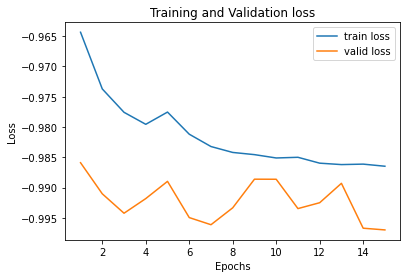

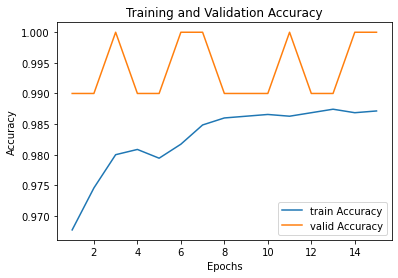

In [1386]:
epochs = range(1,16)
plt.figure()
plt.plot(epochs, np.array(train_Loss_Accuracy_list)[:,0], label='train loss')
plt.plot(epochs, np.array(val_Loss_Accuracy_list)[:,0], label='valid loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Training and Validation loss(ML)', dpi=1000)
plt.figure()
plt.plot(epochs, np.array(train_Loss_Accuracy_list)[:,1], label='train Accuracy')
plt.plot(epochs, np.array(val_Loss_Accuracy_list)[:,1], label='valid Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Training and Validation Accuracy(ML)', dpi=1000)